# MODELING

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd "/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES"

/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES


In [3]:
!ls

Electric_Energy.csv  household_power_consumption.txt


In [4]:
!pwd

/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES


In [5]:
#!pip install -U statsmodels

In [6]:
#Import processing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import os, warnings, gc
warnings.filterwarnings('ignore')
import scipy.stats as stats
import random
seed = 4092
random.seed(seed)
np.random.seed(seed)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

#Time series libraries
from scipy import stats
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import pacf, plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


#Modelling libaries
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from keras.callbacks import EarlyStopping
%matplotlib inline

In [7]:
#Setting display margins
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('ggplot')
plt.rcParams['font.size'] = 10

In [8]:
data = pd.read_csv("household_power_consumption.txt", delimiter=';', parse_dates = {"datetime":[0,1]},
                 low_memory = False, infer_datetime_format=True)
data = data.set_index('datetime')

In [9]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


In [10]:
data.replace({'?': np.nan},inplace=True)

In [11]:
data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
#Dropping duplicated rows
data = data.drop_duplicates(keep = 'first')
print(f"The total sum of duplicated entries is: {data.duplicated().sum()}")
print('Duplicate check shows there are some dupliacte entries', data[data.duplicated()].shape)

The total sum of duplicated entries is: 0
Duplicate check shows there are some dupliacte entries (0, 7)


In [13]:
data.isnull().sum()

Global_active_power      1
Global_reactive_power    1
Voltage                  1
Global_intensity         1
Sub_metering_1           1
Sub_metering_2           1
Sub_metering_3           1
dtype: int64

In [14]:
for cols in data.iloc[:, 0:]:
  data[cols].fillna(value = 1, inplace = True)
pass
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
#Converting data to float data type
def convert(data_type):
  for cols in data_type.columns:
    if data_type[cols].dtype == 'object':
      data_type[cols] = data_type[cols].astype('float')
  return data.dtypes
convert(data)

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [16]:
data.shape

(1906699, 7)

In [17]:
# Data Preprocessing
"""
Since we are using a Recurrent Neural network, it is better to use MinMaxScaler
"""
data1 = data['Global_active_power'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data1) # The fit_transform method converts the data to numpy array stored in dataset variable
print("The type of dataset is {}". format(type(scaled_data)))
print("=================================")
print(scaled_data[:5])
print("=================================")

The type of dataset is <class 'numpy.ndarray'>
[[0.37479631]
 [0.47836321]
 [0.47963064]
 [0.48089806]
 [0.32500453]]


# Model Selection

* AR
* ARIMA
* SARIMA
* LSTM

## Evaluation metrics will be Mean squared error and RMSE

# Data Modeling Using AR Model
* AR stands for Autoregression
* A regression model, such as linear regression, models an output value based on a linear combination of input values.
* Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

## Autocorrelation Check

"""
Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.
"""

In [18]:
lagplot_data = data['Global_active_power'].resample('D').mean()
lagplot_data.shape

(1442,)

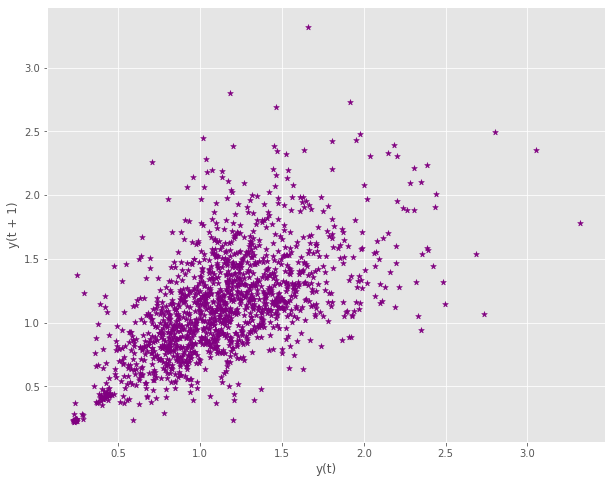

In [19]:
#The plot shows some correlation of present time and future time
plt.figure(figsize = (10,8))
lagplot = lag_plot(lagplot_data, c = 'purple', marker = '*')
lagplot.plot(title = 'Lagplot to check autocorrelation resampled over day')
plt.show()

In [20]:
lagplot_data_df = pd.concat([lagplot_data.shift(-1), lagplot_data], axis = 1)
lagplot_data_df.columns = ['Global_active_power(t)', 'Global_active_power(t+1)']
lagplot_data_corr = lagplot_data_df.corr()
lagplot_data_corr

,Global_active_power(t),Global_active_power(t+1)
Global_active_power(t),1.00,0.60
Global_active_power(t+1),0.60,1.00


In [21]:
lagplot_data1 = data['Global_active_power'].resample('W').mean()
lagplot_data1.shape

(207,)

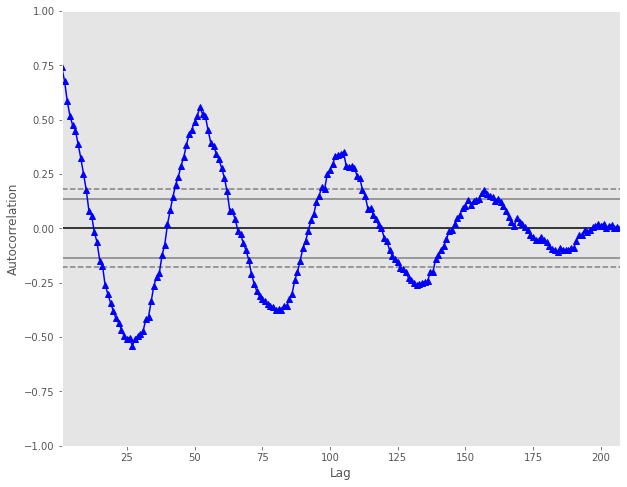

In [22]:
plt.figure(figsize = (10,8))
lagplot1 = autocorrelation_plot(lagplot_data1, c = 'blue', marker = '^')
lagplot1.plot(title = 'Autocorrelation Plot of the Data resampled over Hour')
plt.show()

# Using statsmodel plot_acf and plot_pacf

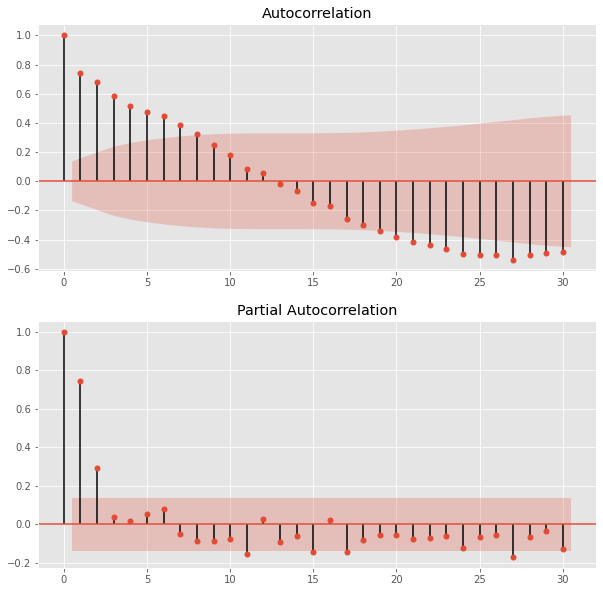

In [23]:
#ACF AND PACF PLOT Shows our p = 7 and q = 1
df1 = data['Global_active_power'].resample('W').agg('mean')
# plots
plt.figure(figsize = (10,10))
lags = 30
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df1, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df1, ax=axis, lags=lags)
# show plot
plt.show()

 The length of train and test are 1906669 and 30 respectively
-------------------------------------------------------
Test MSE: 0.00002870
Test RMSE: 0.00535718
-------------------------------------------------------


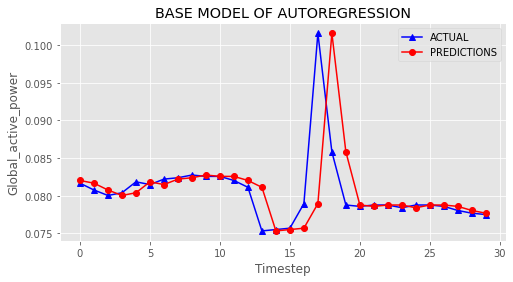

'=======AUTOREGRESSION BASE MODEL DONE======='

In [24]:
#Base model and thresholds
def baseARmodel(dataset):
  from pandas import DataFrame
  X = pd.concat([DataFrame(dataset).shift(1), DataFrame(dataset)], axis = 1)
  X.columns = ['Global_active_power(t-1)', 'Global_active_power(t+1)']
  X = X.values
  train, test = X[:len(dataset)-30], X[len(dataset)-30:]
  print(f" The length of train and test are {len(train)} and {len(test)} respectively")
  X_train, y_train = train[:len(train),0], train[:len(train),-1:]

  X_test, y_test = test[:,0], test[:,1]

  # persistence model
  def model_persistence(x):
	  return x
 
  # walk-forward validation
  predictions = list()
  for x in X_test:
	  yhat = model_persistence(x)
	  predictions.append(yhat)
  test_score = mean_squared_error(y_test, predictions)

  print("-------------------------------------------------------")
  print('Test MSE: %.8f' % test_score)
  print('Test RMSE: %.8f' % np.sqrt(test_score))
  print("-------------------------------------------------------")

  # plot predictions vs expected
  plt.figure(figsize=(8,4))
  plt.plot(y_test, color = 'blue',marker = '^', label = 'ACTUAL')
  plt.plot(predictions, color='red', marker = 'o', label = 'PREDICTIONS')
  plt.title("BASE MODEL OF AUTOREGRESSION")
  plt.xlabel('Timestep')
  plt.ylabel('Global_active_power')
  plt.legend()
  plt.show()

  return '=======AUTOREGRESSION BASE MODEL DONE======='
baseARmodel(scaled_data)

========Trainng finished successfully======= 

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:              1906669
Model:                    AutoReg(30)   Log Likelihood             4366978.201
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Wed, 11 Nov 2020   AIC                             -7.419
Time:                        21:03:48   BIC                             -7.418
Sample:                            30   HQIC                            -7.419
                              1906669                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020   2.69e-05     75.529      0.000       0.002       0.002
y.L1           1.0041      0.001   1386.432      0.000       1.003       1.005
y.L2 

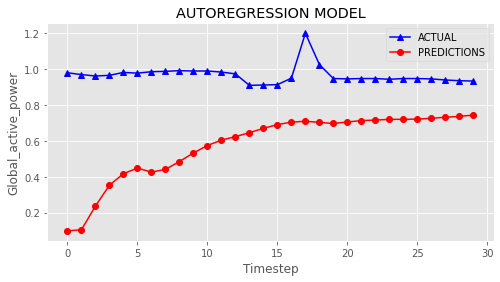

'=======AUTOREGRESSION  DONE======='

In [25]:
def ar_model(dataset):
  """
  Training the data with Auto regression Model
  """
  X = dataset
  train, test = X[:len(X)-30], X[len(X)-30:]

  autoreg = AutoReg(train, lags = 30)
  autoreg_fit = autoreg.fit()

  print("========Trainng finished successfully=======",'\n')
  print(autoreg_fit.summary())
  
  print("============================================================")
  print("Model coefficients are: %s" % autoreg_fit.params)
  print("============================================================")

  # fig = plt.figure(figsize=(16,9))
  # fig = autoreg_fit.plot_diagnostics(fig=fig, lags=30)


  predictions = autoreg.predict(autoreg_fit.params, start = len(train), end = len(train)+len(test)-1, dynamic = True)

  for pred in range(len(predictions)):
    print('predicted_values%f, expected_values=%f' % (predictions[pred], test[pred]))

  test = scaler.inverse_transform(test)
  predictions = scaler.inverse_transform([predictions])
  MSE = mean_squared_error(test, predictions[0])
  RMSE = np.sqrt(MSE)
  print("============================================================")
  print("Test Mean Squred Error: %0.5f" % MSE)
  print("Test Root Mean Squred Error: %0.5f" % RMSE)
  print("============================================================")

  #ig = autoreg_fit.plot_predict(start = len(train), end = len(train)+len(test)-1)

   # plot predictions vs expected
  plt.figure(figsize=(8,4))
  plt.plot(test, color = 'blue',marker = '^', label = 'ACTUAL')
  plt.plot(predictions[0], color='red', marker = 'o', label = 'PREDICTIONS')
  plt.title("AUTOREGRESSION MODEL")
  plt.xlabel('Timestep')
  plt.ylabel('Global_active_power')
  plt.legend()
  plt.show()
  return '=======AUTOREGRESSION  DONE======='

ar_model(scaled_data)

# Data Modeling Using ARIMA Model

* ARIMA stands for Autoregressive Integrated Moving Average.
* It depends on 3 important parametres
1. Number Autoregression(AR) term paramentre(p)
2. Number of Moving Average(MA) term(q)
3. Number of Difference(d, usually 0 or 1)

### Determing p and q
* To determine these terms, we are going to use Autocorrelation Function(ACF) and Passive Auto Correlation Function(PACF) plots.

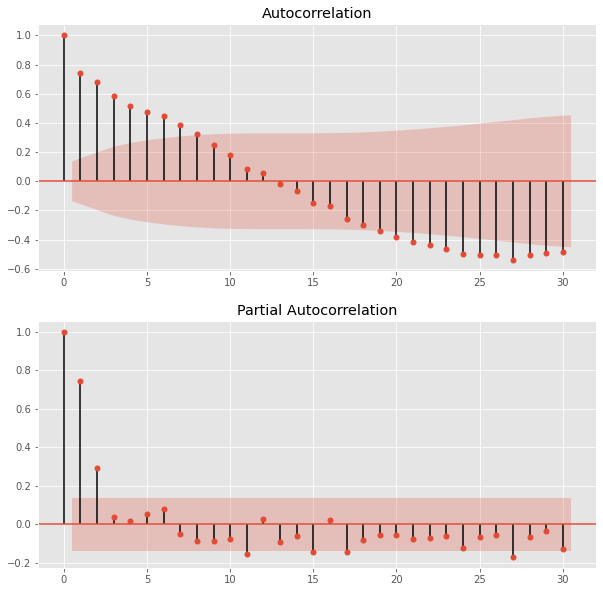

In [26]:
df1 = data['Global_active_power'].resample('W').agg('mean')
# plots
plt.figure(figsize = (10,10))
lags = 30
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df1, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df1, ax=axis, lags=lags)
# show plot
plt.show()

In [27]:
df2 = data['Global_active_power'].resample('D').agg('mean')
df2.fillna(data['Global_active_power'].mean(),inplace=True)
df2  = df2.values.reshape(-1,1)

df2_scaled = scaler.fit_transform(df2)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1152
Model:                 ARIMA(7, 1, 0)   Log Likelihood                 995.195
Method:                       css-mle   S.D. of innovations              0.102
Date:                Wed, 11 Nov 2020   AIC                          -1972.389
Time:                        21:11:23   BIC                          -1926.946
Sample:                             1   HQIC                         -1955.237
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.153      0.878      -0.002       0.002
ar.L1.D.y     -0.6114      0.029    -20.748      0.000      -0.669      -0.554
ar.L2.D.y     -0.5917      0.034    -17.262      0.0

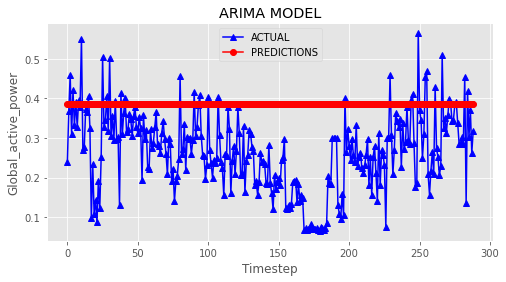

+++++++++++Residual Plot++++++++++


<Figure size 576x288 with 0 Axes>

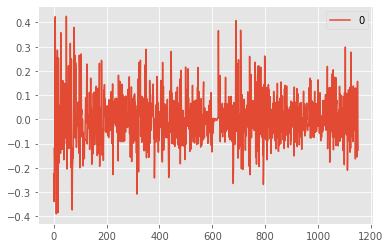

<Figure size 576x288 with 0 Axes>

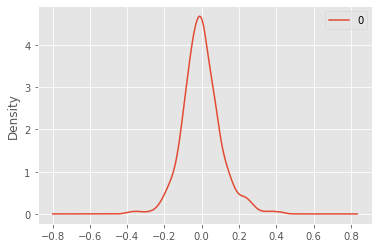

            0
count 1152.00
mean    -0.00
std      0.10
min     -0.39
25%     -0.06
50%     -0.01
75%      0.05
max      0.43


'====ARIMA MODELING DONE===='

In [28]:
# fit model
def arima_model(dataset):
  
  """
  ARIMA modelling
  #ACF AND PACF PLOT Shows our p = 7, d = 1 and q = 0
  """
  train_size = int(0.8*(len(dataset)))
  train, test = dataset[:train_size], dataset[train_size:len(dataset)]

  train_data = [x for x in train]
  predictions = list()
  y_test = list()

  for tests in range(len(test)):
    model = ARIMA(train_data, order=(7,1,0))
    model_fit = model.fit(disp=0)
    
    forecast = model_fit.forecast()
    yhat = forecast[0]
    predictions.append(yhat)

    y_true = test[tests]
    y_test.append(y_true)
  print(model_fit.summary())
  print("======Training Finished Successfully======")
  print("======Forecasting Finished Successfully======")


  MSE = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(predictions))
  RMSE = np.sqrt(MSE)

  print("=====================================================")
  print("Test MSE Error: %0.5f" % MSE)
  print("Test RMSE Error: %0.5f" %RMSE)
  print("=====================================================")

  # plot predictions vs expected
  plt.figure(figsize=(8,4))
  plt.plot(y_test, color = 'blue',marker = '^', label = 'ACTUAL')
  plt.plot(predictions, color='red', marker = 'o', label = 'PREDICTIONS')
  plt.title("ARIMA MODEL")
  plt.xlabel('Timestep')
  plt.ylabel('Global_active_power')
  plt.legend()
  plt.show()

  print("+++++++++++Residual Plot++++++++++")
  # plot residual errors
  residuals = pd.DataFrame(model_fit.resid)
  plt.figure(figsize=(8,4))
  residuals.plot()
  plt.show()
  plt.figure(figsize=(8,4))
  residuals.plot(kind='kde')
  plt.show()
  print(residuals.describe())

  return "====ARIMA MODELING DONE===="
arima_model(df2_scaled)

# Using SARIMAX model

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1153
Model:             SARIMAX([5, 7, 12, 13], 0, 0)   Log Likelihood                 839.798
Date:                           Wed, 11 Nov 2020   AIC                          -1669.597
Time:                                   21:40:16   BIC                          -1644.346
Sample:                                        0   HQIC                         -1660.066
                                          - 1153                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L5          0.2140      0.024      9.018      0.000       0.167       0.260
ar.L7          0.4715      0.022     21.692

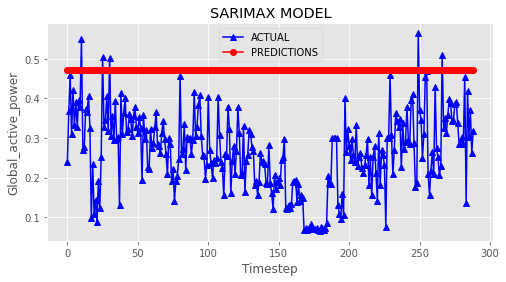

+++++++++++Residual Plot++++++++++


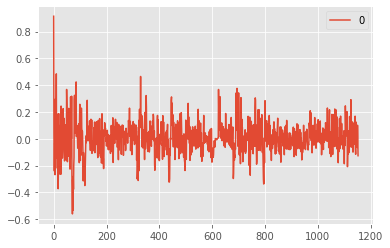

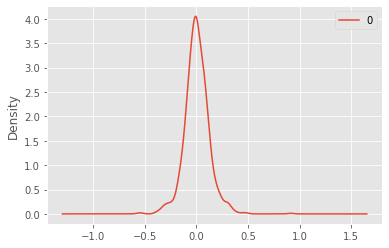

            0
count 1153.00
mean     0.01
std      0.12
min     -0.56
25%     -0.06
50%      0.00
75%      0.07
max      0.91


'====SARIMAX MODELING DONE===='

In [30]:
# fit model
def sarimax_model(dataset):
  
  """
  SARIMAX modelling
  #ACF AND PACF PLOT Shows our p = 7, d = 1 and q = 0
  """
  train_size = int(0.8*(len(dataset)))
  train, test = dataset[:train_size], dataset[train_size:len(dataset)]

  train_data = [x for x in train]
  predictions = list()
  y_test = list()

  for tests in range(len(test)):
    model = SARIMAX(train_data,order=((7,5,12,13),0, 0))
    model_fit = model.fit(disp=0)
    
    forecast = model_fit.forecast()
    yhat = forecast[0]
    predictions.append(yhat)

    y_true = test[tests]
    y_test.append(y_true)
  print(model_fit.summary())
  print("======Training Finished Successfully======")
  print("======Forecasting Finished Successfully======")


  MSE = mean_squared_error(y_test,predictions)
  RMSE = np.sqrt(MSE)

  print("=====================================================")
  print("Test MSE Error: %0.5f" % MSE)
  print("Test RMSE Error: %0.5f" %RMSE)
  print("=====================================================")

  # plot predictions vs expected
  plt.figure(figsize=(8,4))
  plt.plot(y_test, color = 'blue',marker = '^', label = 'ACTUAL')
  plt.plot(predictions, color='red', marker = 'o', label = 'PREDICTIONS')
  plt.title("SARIMAX MODEL")
  plt.xlabel('Timestep')
  plt.ylabel('Global_active_power')
  plt.legend()
  plt.show()

  print("+++++++++++Residual Plot++++++++++")
  # plot residual errors
  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  plt.show()
  residuals.plot(kind='kde')
  plt.show()
  print(residuals.describe())

  return "====SARIMAX MODELING DONE===="
sarimax_model(df2_scaled)

## Using LSTM
### Model Archtecture
* One dense layer
* Used Dropout regularization with dropout of 0.2

=====Converting an array of values into a dataset matrix done successfully===== 

====Reshaping input to be [samples, no_features, time steps] done successfully==== 

(1525328, 1, 30) (381309, 1, 30) (1525328,) (381309,)
Epoch 1/20
21791/21791 [==============================] - 64s 3ms/step - loss: 8.2768e-04 - val_loss: 4.9236e-04
Epoch 2/20
21791/21791 [==============================] - 68s 3ms/step - loss: 7.0665e-04 - val_loss: 4.4742e-04
Epoch 3/20
21791/21791 [==============================] - 66s 3ms/step - loss: 6.9530e-04 - val_loss: 4.3911e-04
Epoch 4/20
21791/21791 [==============================] - 64s 3ms/step - loss: 6.9098e-04 - val_loss: 4.3377e-04
Epoch 5/20
21791/21791 [==============================] - 64s 3ms/step - loss: 6.8425e-04 - val_loss: 4.3669e-04
Epoch 6/20
21791/21791 [==============================] - 67s 3ms/step - loss: 6.8074e-04 - val_loss: 4.2551e-04
Epoch 7/20
21791/21791 [==============================] - 63s 3ms/step - loss: 6.7810e-04 - val_loss:

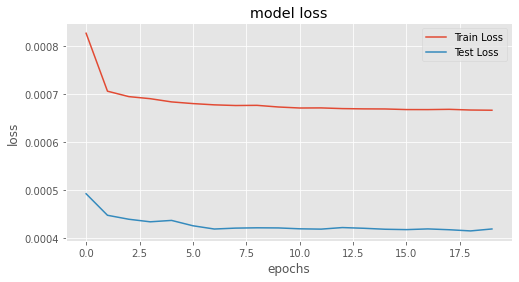

======comparing the actual and predictions for the last 500 minutes======


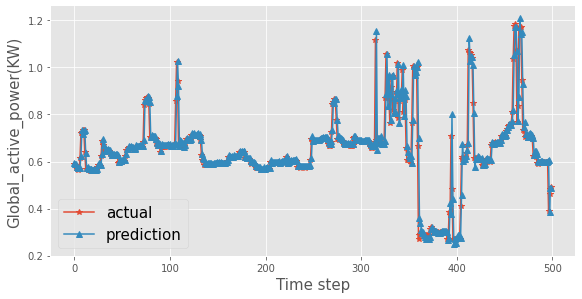

'=====LSTM MODELING DONE====='

In [31]:
# Creating Training and Testing Dataset

def lstm_model(dataset):
    train_size = int(len(dataset)*0.8)
    test_size = int(len(dataset)*0.2)

    train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]


    print("=====Converting an array of values into a dataset matrix done successfully=====",'\n')
    def create_dataset(dataset, look_back):
        X, Y = [], []
        for i in range(len(dataset)-look_back-1):
            x1 = dataset[i:(i+look_back), 0]
            X.append(x1)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    X_train, y_train = create_dataset(train, 30)
    X_test, y_test = create_dataset(test,30)

    print("====Reshaping input to be [samples, no_features, time steps] done successfully====",'\n')
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

    print(model.summary())

    print("=================Making Prediction=================")

    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)

    #Since we transformed our training and test data, we need to inverse it to get the real predicted values
    train_prediction = scaler.inverse_transform(train_prediction)
    y_train = scaler.inverse_transform([y_train])

    test_prediction = scaler.inverse_transform(test_prediction)
    y_test = scaler.inverse_transform([y_test])

    print("===========Evaluating the Model=============")
    print("--------------------------------------------")
    print("===========Mean Square Error and RMSE=======",'\n')


    print(f"The Train Mean Suared Error is {round(mean_squared_error(y_train[0], train_prediction[:,0]),3)}")
    print(f"The Train Root Mean Suared Error is {round(np.sqrt(mean_squared_error(y_train[0], train_prediction[:,0])),3)}")

    print(f"The Test Mean Suared Error is {round(mean_squared_error(y_test[0], test_prediction[:,0]),3)}")
    print(f"The Test Root Mean Suared Error is {round(np.sqrt(mean_squared_error(y_test[0], test_prediction[:,0])),3)}")

    print("++++++++Ploting Model Loss+++++++++++",'\n')
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    plt.show();

    print("======comparing the actual and predictions for the last 500 minutes======")
    data_list = [x for x in range(500)]
    plt.figure(figsize=(8,4))
    plt.plot(data_list, y_test[0][:500], marker='*', label="actual")
    plt.plot(data_list, test_prediction[:,0][:500], marker = '^', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Global_active_power(KW)', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();
    
    return "=====LSTM MODELING DONE====="
lstm_model(scaled_data)

# MSE AND RMSE PLOT OF VARIOUS MODELS

In [32]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
eval = {"model": ["AR","ARIMA", "SARIMA", "LSTM"],
        "MSE": [0.18820,0.23546, 0.05259,0.004],
        "RMSE":[0.43382, 0.48524, 0.22933,0.063]
      }
models = pd.DataFrame(eval)
models.head()


,model,MSE,RMSE
0,AR,0.18820,0.43382
1,ARIMA,0.23546,0.48524
2,SARIMA,0.05259,0.22933
3,LSTM,0.00400,0.06300


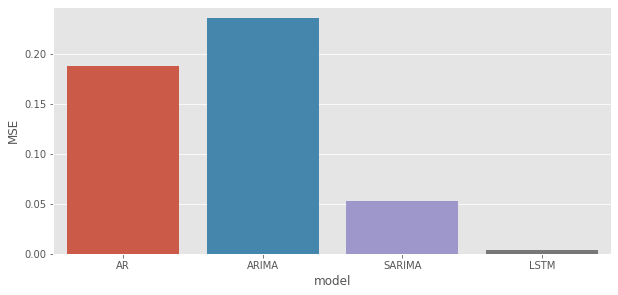

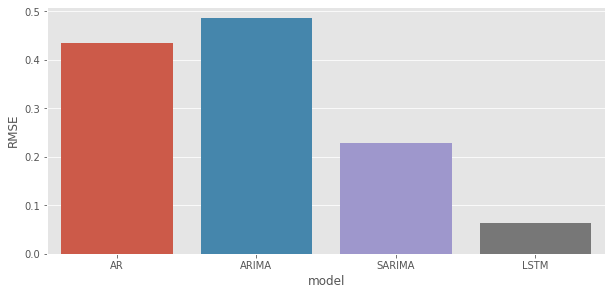

In [38]:
plt.figure(figsize = (10,10))
ax = plt.subplot(2,1,1)
ax = sns.barplot(data = models, x = 'model', y = 'MSE', orient = 'v')
plt.show()
plt.figure(figsize = (10,10))
ax1 = plt.subplot(2,1,2)
ax1 = sns.barplot(data = models, x = 'model', y = 'RMSE', orient = 'v')
plt.show()

* The best model is LSTM. Things to note about LSTM are:
1. Is a RNN 
2. Is highly flexible
3. Is suitable for large volume dataset  which good in our case having over 2M entries.
4. LSTM have the ability to figure out or understand the hidden pattern in the given dataset.
5. LSTM is good for timeseries modeling because of its recurrent nature(RNN)

# The End